In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
cnt = Counter()
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cdroin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/cdroin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


### Load dataset

In [2]:
df_init = pd.read_csv('emilia.csv')

In [3]:
df_init

,Movie,Title,Content,Rate,Upvotes,Downvotes,Polarity,Subjectivity
0,NaN,The Worst representation of Mexico's actual dr...,"I am Mexican, and I can tell you that this mov...",5.0,1122,116,-0.072917,0.370833
1,NaN,A Tone-Deaf Musical Disaster,Emilia Pérez has sparked significant controver...,4.0,20,2,0.041363,0.461892
2,NaN,"okay, so",The problem with this movie is not Selenas Spa...,6.0,383,104,-0.019231,0.435897
3,NaN,Not Worth Your Time,I will start out by saying I am not a fan of o...,NaN,636,69,-0.000159,0.526243
4,NaN,"Emilia Perez: Ambitious Themes, Incomplete Exe...","Emilia Perez isnt a bad movie, but it felt som...",6.0,186,128,0.111898,0.456105
...,...,...,...,...,...,...,...,...
474,NaN,Feels silly trying to embrace this misbegotten...,A veteran criminal defense attorney in Mexico ...,3.0,2,1,0.038889,0.551389
475,NaN,Should not work on ANY level - yet has enough ...,"First and foremost, this is a French film abou...",5.0,2,5,0.088027,0.483809
476,NaN,Tone-deaf in more than one sense.,"I was stunned after watching Emilia Perez, but...",5.0,1,6,0.066786,0.427820
477,NaN,A wild entertaining ride that overwhelms itself.,"It mixes so many ideas, themes and genres into...",5.0,2,20,0.180333,0.465952


<Axes: ylabel='Frequency'>

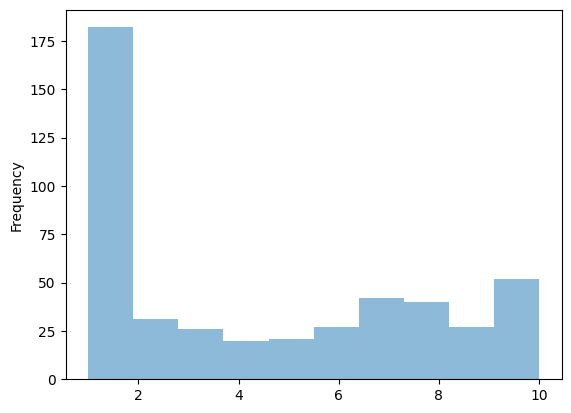

In [4]:
# Plot distribution of rate 
df_init['Rate'].plot.hist(bins=10, alpha=0.5)

### Filter and group

In [5]:
# Only keep reviews with Rate 1 or 2 (group negative), 5 or 6 (group neutral), 9 or 10 (group positive)
df_filtered = df_init[df_init['Rate'].isin([1, 2, 4,5, 6, 9, 10])]

# Add a new column 'Sentiment' to the dataframe
df_filtered['Sentiment'] = df_filtered['Rate'].apply(lambda x: -1 if x in [1, 2] else 0 if x in [4,5, 6] else 1)


/var/folders/l8/7h5sfbjn2ng3kg7y8p21r8qr0000gn/T/ipykernel_26173/3270839814.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Sentiment'] = df_filtered['Rate'].apply(lambda x: -1 if x in [1, 2] else 0 if x in [4,5, 6] else 1)


In [6]:
df_filtered

,Movie,Title,Content,Rate,Upvotes,Downvotes,Polarity,Subjectivity,Sentiment
0,NaN,The Worst representation of Mexico's actual dr...,"I am Mexican, and I can tell you that this mov...",5.0,1122,116,-0.072917,0.370833,0
1,NaN,A Tone-Deaf Musical Disaster,Emilia Pérez has sparked significant controver...,4.0,20,2,0.041363,0.461892,0
2,NaN,"okay, so",The problem with this movie is not Selenas Spa...,6.0,383,104,-0.019231,0.435897,0
4,NaN,"Emilia Perez: Ambitious Themes, Incomplete Exe...","Emilia Perez isnt a bad movie, but it felt som...",6.0,186,128,0.111898,0.456105,0
6,NaN,Overhyped!,"Emilia Pérez is, at best, just okay. It feels ...",6.0,59,38,0.281961,0.508480,0
...,...,...,...,...,...,...,...,...,...
472,NaN,An original Thriller with a twist,Emilia Perez is a 2024 Foreign LGBT Thriller s...,5.0,4,10,0.240278,0.554321,0
473,NaN,"Good subject and acting ,but Bad Movie , Bad E...",Emilia Pérez is a 2024 Spanish language French...,5.0,3,8,0.131590,0.473103,0
475,NaN,Should not work on ANY level - yet has enough ...,"First and foremost, this is a French film abou...",5.0,2,5,0.088027,0.483809,0
476,NaN,Tone-deaf in more than one sense.,"I was stunned after watching Emilia Perez, but...",5.0,1,6,0.066786,0.427820,0


<Axes: ylabel='Frequency'>

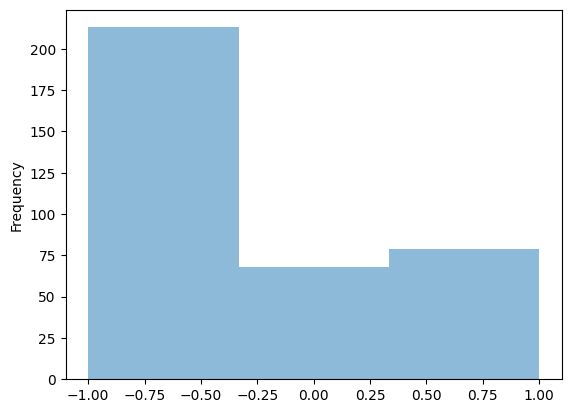

In [7]:
# PLot distribution of sentiment
df_filtered['Sentiment'].plot.hist(bins=3, alpha=0.5)

In [8]:
# Merge title with review
df_filtered['Title_Content'] = df_filtered['Title'] + ' ' + df_filtered['Content']

# Remove columns Polarity and Subjectivity
df_filtered = df_filtered.drop(columns=['Polarity', 'Subjectivity'])

df_filtered

/var/folders/l8/7h5sfbjn2ng3kg7y8p21r8qr0000gn/T/ipykernel_26173/1842719313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Title_Content'] = df_filtered['Title'] + ' ' + df_filtered['Content']


,Movie,Title,Content,Rate,Upvotes,Downvotes,Sentiment,Title_Content
0,NaN,The Worst representation of Mexico's actual dr...,"I am Mexican, and I can tell you that this mov...",5.0,1122,116,0,The Worst representation of Mexico's actual dr...
1,NaN,A Tone-Deaf Musical Disaster,Emilia Pérez has sparked significant controver...,4.0,20,2,0,A Tone-Deaf Musical Disaster Emilia Pérez has ...
2,NaN,"okay, so",The problem with this movie is not Selenas Spa...,6.0,383,104,0,"okay, so The problem with this movie is not Se..."
4,NaN,"Emilia Perez: Ambitious Themes, Incomplete Exe...","Emilia Perez isnt a bad movie, but it felt som...",6.0,186,128,0,"Emilia Perez: Ambitious Themes, Incomplete Exe..."
6,NaN,Overhyped!,"Emilia Pérez is, at best, just okay. It feels ...",6.0,59,38,0,"Overhyped! Emilia Pérez is, at best, just okay..."
...,...,...,...,...,...,...,...,...
472,NaN,An original Thriller with a twist,Emilia Perez is a 2024 Foreign LGBT Thriller s...,5.0,4,10,0,An original Thriller with a twist Emilia Perez...
473,NaN,"Good subject and acting ,but Bad Movie , Bad E...",Emilia Pérez is a 2024 Spanish language French...,5.0,3,8,0,"Good subject and acting ,but Bad Movie , Bad E..."
475,NaN,Should not work on ANY level - yet has enough ...,"First and foremost, this is a French film abou...",5.0,2,5,0,Should not work on ANY level - yet has enough ...
476,NaN,Tone-deaf in more than one sense.,"I was stunned after watching Emilia Perez, but...",5.0,1,6,0,Tone-deaf in more than one sense. I was stunne...


### Clean and transform text

In [9]:
# Clean text


def cleaning(text):        
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower() # converting to lowercase
    text = re.sub('https?://\S+|www\.\S+', '', text) # removing URL links
    text = re.sub(r"\b\d+\b", "", text) # removing number 
    text = re.sub('<.*?>+', '', text) # removing special characters, 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # punctuations
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
   
    #removing emoji: 
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)   

   # removing short form: 
    
    text=re.sub("isn't",'is not',text)
    text=re.sub("he's",'he is',text)
    text=re.sub("wasn't",'was not',text)
    text=re.sub("there's",'there is',text)
    text=re.sub("couldn't",'could not',text)
    text=re.sub("won't",'will not',text)
    text=re.sub("they're",'they are',text)
    text=re.sub("she's",'she is',text)
    text=re.sub("There's",'there is',text)
    text=re.sub("wouldn't",'would not',text)
    text=re.sub("haven't",'have not',text)
    text=re.sub("That's",'That is',text)
    text=re.sub("you've",'you have',text)
    text=re.sub("He's",'He is',text)
    text=re.sub("what's",'what is',text)
    text=re.sub("weren't",'were not',text)
    text=re.sub("we're",'we are',text)
    text=re.sub("hasn't",'has not',text)
    text=re.sub("you'd",'you would',text)
    text=re.sub("shouldn't",'should not',text)
    text=re.sub("let's",'let us',text)
    text=re.sub("they've",'they have',text)
    text=re.sub("You'll",'You will',text)
    text=re.sub("i'm",'i am',text)
    text=re.sub("we've",'we have',text)
    text=re.sub("it's",'it is',text)
    text=re.sub("don't",'do not',text)
    text=re.sub("that´s",'that is',text)
    text=re.sub("I´m",'I am',text)
    text=re.sub("it’s",'it is',text)
    text=re.sub("she´s",'she is',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('I’m','I am',text)
    text=re.sub('I’d','I did',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('there’s','there is',text)
    
     
    return text
    


In [10]:
df_final = df_filtered['Title_Content'].apply(cleaning)

# Rename column Title_Content to text
df_final = df_final.to_frame().rename(columns={'Title_Content': 'text'})

In [11]:
df_final['sentiment'] = df_filtered['Sentiment']

In [12]:
df_final

,text,sentiment
0,the worst representation of mexicos actual dru...,0
1,a tonedeaf musical disaster emilia pérez has s...,0
2,okay so the problem with this movie is not sel...,0
4,emilia perez ambitious themes incomplete execu...,0
6,overhyped emilia pérez is at best just okay it...,0
...,...,...
472,an original thriller with a twist emilia perez...,0
473,good subject and acting but bad movie bad exe...,0
475,should not work on any level yet has enough s...,0
476,tonedeaf in more than one sense i was stunned ...,0


In [13]:
# remove stop word: 
stop_words = stopwords.words()
df_final['text'] = df_final['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [14]:
df_final

,text,sentiment
0,worst representation mexicos actual problems m...,0
1,tonedeaf musical disaster emilia pérez sparked...,0
2,problem movie selenas spanish find movie parti...,0
4,emilia perez ambitious themes incomplete execu...,0
6,overhyped emilia pérez feels incredibly overhy...,0
...,...,...
472,original thriller twist emilia perez foreign l...,0
473,subject acting movie execution emilia pérez sp...,0
475,work level standout scenes match massive faili...,0
476,tonedeaf stunned watching emilia perez wrong r...,0


In [15]:
for text in df_final['text'].values:
    for word in text.split():
        cnt[word] += 1
temp = pd.DataFrame(cnt.most_common(40))
temp.columns=['word', 'count']
temp

,word,count
0,movie,661
1,film,566
2,emilia,294
3,musical,281
4,mexican,225
5,mexico,187
6,story,181
7,spanish,167
8,make,140
9,time,132


In [16]:
# Remove the most frequent words:
FREQWORDS = set([w for (w, wc) in cnt.most_common(40)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
df_final["text"] = df_final["text"].apply(lambda text: remove_freqwords(text))
df_final.head()

,text,sentiment
0,representation mexicos actual problems awful r...,0
1,tonedeaf disaster sparked significant controve...,0
2,problem selenas find particularly dialogue cri...,0
4,ambitious themes incomplete execution felt fla...,0
6,overhyped incredibly overhyped honestly unders...,0


In [17]:
df_final

,text,sentiment
0,representation mexicos actual problems awful r...,0
1,tonedeaf disaster sparked significant controve...,0
2,problem selenas find particularly dialogue cri...,0
4,ambitious themes incomplete execution felt fla...,0
6,overhyped incredibly overhyped honestly unders...,0
...,...,...
472,original thriller twist foreign lgbt thriller ...,0
473,subject execution language french crime comedy...,0
475,level standout scenes match massive failings f...,0
476,tonedeaf stunned watching wrong reasonsi deny ...,0


In [18]:
wordnet_lem = WordNetLemmatizer()

def lemmatize(text):
    text = " ".join([wordnet_lem.lemmatize(word) for word in text.split()])
    
    # Only keep adjectives (JJ, JJR, JJS)
    text = ' '.join([word for word, pos in pos_tag(text.split()) if pos in ['JJ', 'JJR', 'JJS'] and word not in ['ive','french', 'mexican']])
    return text

df_final['text'] = df_final['text'].apply(lemmatize)
df_final

,text,sentiment
0,actual awful narcotic interesting ridiculous s...,0
1,significant oversight insult dismissive academ...,0
2,dialogue cringy stereotypical real latin respe...,0
4,ambitious incomplete flat easy particular posi...,0
6,understand strong element uneven sluggish emot...,0
...,...,...
472,original foreign lgbt gomezzoe saldana perezno...,0
473,subject audiard libretto unexpected emotional ...,0
475,massive input justified entire latin short fla...,0
476,wrong innovative nonsense tonedeaf unsensitive...,0


### Tokenize

In [19]:
tokenized_review=df_final['text'].apply(lambda x: x.split())
tokenized_review.head(5)

0    [actual, awful, narcotic, interesting, ridicul...
1    [significant, oversight, insult, dismissive, a...
2    [dialogue, cringy, stereotypical, real, latin,...
4    [ambitious, incomplete, flat, easy, particular...
6    [understand, strong, element, uneven, sluggish...
Name: text, dtype: object

In [20]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df_final['text'])

/Users/cdroin/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
text_counts

<360x1966 sparse matrix of type '<class 'numpy.int64'>'
	with 5258 stored elements in Compressed Sparse Row format>

### Classify

In [22]:
X=text_counts
y=df_final['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=30)

In [23]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

MultinominalNB model accuracy is 75.00%
------------------------------------------------
Confusion Matrix:
    0  1   2
0  33  5   2
1   2  6   3
2   3  3  15
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.82      0.85        40
           0       0.43      0.55      0.48        11
           1       0.75      0.71      0.73        21

    accuracy                           0.75        72
   macro avg       0.68      0.69      0.69        72
weighted avg       0.77      0.75      0.76        72



In [24]:
MNB.class_count_

array([173.,  57.,  58.])

In [25]:
MNB.feature_log_prob_

# Only keep the 10 best word for each class, display the corresponding words
n = 20
for i, label in enumerate(MNB.classes_):
    top_n = np.argsort(MNB.feature_log_prob_[i])[-n:]
    print(label, [cv.get_feature_names_out()[i] for i in top_n])


-1 ['american', 'poor', 'entire', 'touch', 'shallow', 'wrong', 'high', 'lyric', 'speak', 'ridiculous', 'social', 'cultural', 'narrative', 'horrible', 'disrespectful', 'real', 'awful', 'hard', 'offensive', 'terrible']
0 ['terrible', 'subject', 'past', 'unique', 'entire', 'important', 'golden', 'understand', 'hard', 'musical', 'lead', 'real', 'emotional', 'narrative', 'different', 'strong', 'interesting', 'ambitious', 'big', 'wrong']
1 ['female', 'sad', 'narrative', 'rita', 'past', 'complete', 'unforgettable', 'happy', 'raw', 'powerful', 'emotional', 'brilliant', 'big', 'different', 'unique', 'musical', 'incredible', 'real', 'beautiful', 'original']


In [26]:
# Redo the classification with only the 20 best words for each class (remove the other words in text_counts)
n = 20
top_n_1 = []
for i, label in enumerate(MNB.classes_):
    top_n_1 += list(np.argsort(MNB.feature_log_prob_[i])[-n:])
top_n_1 = list(set(top_n_1))

# Only keep words for which the std is above a certain threshold
# threshold = 0.05
# top_n_2 = []
# for i, label in enumerate(MNB.classes_):
#     top_n_2 += list(np.where(np.std(text_counts[:, np.argsort(MNB.feature_log_prob_[i])], axis=0) > threshold)[0])
    
# top_n_2 = list(set(top_n_2))

top_n = top_n_1#list(set(top_n_1) & set(top_n_2))

X = text_counts[:, top_n]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=30)


MNB = MultinomialNB()
MNB.fit(X_train, y_train)

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

MultinominalNB model accuracy is 72.22%
------------------------------------------------
Confusion Matrix:
    0  1   2
0  35  4   1
1   7  2   2
2   6  0  15
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

          -1       0.73      0.88      0.80        40
           0       0.33      0.18      0.24        11
           1       0.83      0.71      0.77        21

    accuracy                           0.72        72
   macro avg       0.63      0.59      0.60        72
weighted avg       0.70      0.72      0.70        72



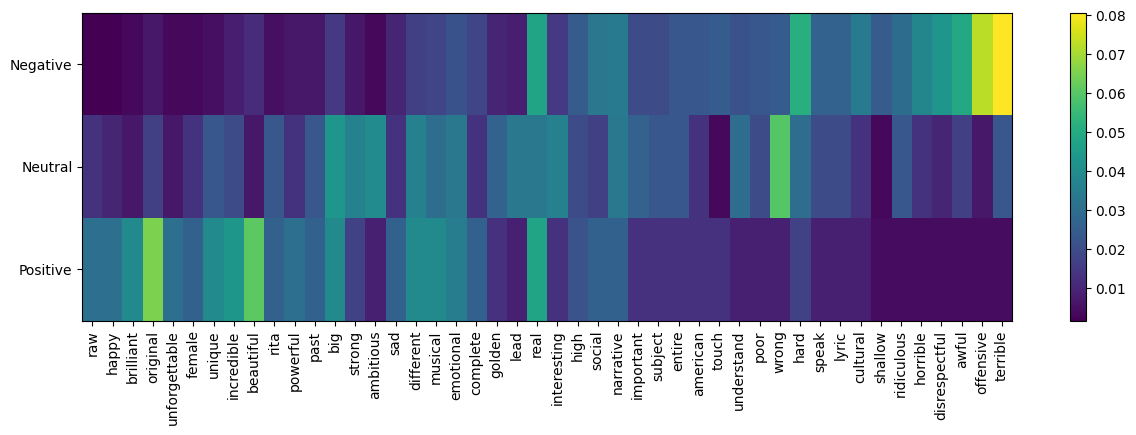

In [31]:
# Plot the matrix of probabilities per word
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 4))
# Sort MNB.feature_log_prob_ by increasing difference between row 0 and row 2
order = np.argsort(MNB.feature_log_prob_[0] - MNB.feature_log_prob_[2])
words = [cv.get_feature_names_out()[i] for i in top_n]
words_sorted = [words[i] for i in order]


plt.imshow(np.exp(MNB.feature_log_prob_[:, order]), cmap='viridis', aspect='auto')
plt.colorbar()
plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'])
plt.xticks(range(len(order)), words_sorted, rotation=90)
plt.show()


In [28]:
X_train

<288x46 sparse matrix of type '<class 'numpy.int64'>'
	with 828 stored elements in Compressed Sparse Row format>